<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-необходимых-библиотек" data-toc-modified-id="Импорт-необходимых-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт необходимых библиотек</a></span></li><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование-моделей-и-вывод" data-toc-modified-id="Тестирование-моделей-и-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование моделей и вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**План работы:**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделть выводы.

**Описание данных:**

Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score


import timeit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', None)

RAST = 99

from urllib.request import urlopen
from PIL import Image
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Изучение данных

Загрузим данные

In [2]:
try:  
    df_toxic = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df_toxic = pd.read_csv(r'C:\Users\Admiral\Desktop\учеба\практикум\Проекты\Datasets\12_toxic_comments.csv')

Выведем общую информацию

In [3]:
df_toxic.info()
display(df_toxic['toxic'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


0    143346
1     16225
Name: toxic, dtype: int64

Имеем 159571 наблюдение, один признак в котором содержатся тексты комментариев и целевой категориальный признак с разделением на негативные (1) и позитивные (0) комментарии. Пропуски отсутствуют. Изменим тип данных целевого признака на uint8.

In [4]:
df_toxic['toxic'] = df_toxic['toxic'].astype('uint8')

Проверим наличие дубликатов по комментариям

In [5]:
print(f'Количество дубликатов в текстах: {df_toxic.text.duplicated().sum()} шт.')

Количество дубликатов в текстах: 0 шт.


Изучим баланс целевого признака

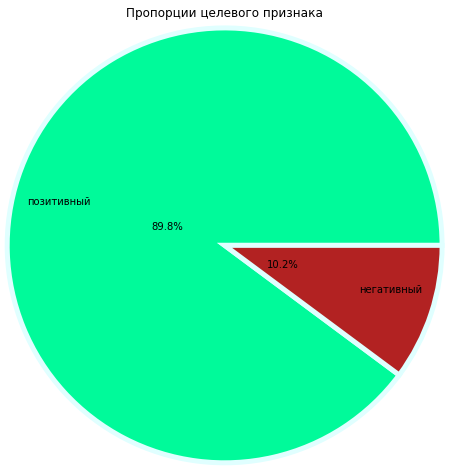

In [6]:
plt.pie(df_toxic.groupby('toxic')['toxic'].count(),\
        colors = {'#00FA9A': '0', '#B22222':'1'},\
        labels={'позитивный': '0', 'негативный':'1'},\
        labeldistance=0.65, pctdistance=0.28, autopct='%1.1f%%', radius=2.5,\
        wedgeprops = { 'linewidth' : 5, 'edgecolor' : '#E0FFFF' })
plt.title('Пропорции целевого признака', pad=120)
plt.show()

Наблюдаем сильный дисбаланс классов целевого признака в соотношении примерно 1:9, нужно это учесть при разделении на обучающую и тестовую выборки. Изучим 7 случайных комментариев (было изучено больше строк с различными значениями random_state, но вывожу только этот вариант)

In [7]:
display(df_toxic.sample(7, random_state=RAST))

,text,toxic
123678,"I understand what you are getting at and I can't blame you. I think I got a bit carried away; with the benefit of hindsight, I think I should perhaps handled the whole issue in a different manner. As far as having had previous accounts goes, no, this is my first account here. And also, I have no connection to any particular movement of the Libertarian Socialist family; what led me was pure curiosity, as these movements were first mentioned in an offline discussion I had with some friends of mine; they suggested that I do some research and see if I find something that I can relate to. I hoped that by adding that tag I could get other people, more knowledgeable than me, to help improve that article. I never thought it would lead to an edit war and I am honestly sorry for becoming part of a problem.",0
57092,"got a fellow loser to tell me off did you? Think I give a fuck?! \n\nBlock me then you co**sucker - clever people don't give a f*ck about editing Wikipedia? Just because Wikipedia has turned you into its b*tch, you can't see that being blocked is not a 'punishment'. If it happened to you it would be a blessing, but you'll never see how much time and life you've completely WASTED, because your brain is mush. Fuc*in wretch. Now get back to looking at Raw guest hosts and other childish wrestling topics. You make me sick - a grown man devoting his life to watching basted men in pants pretending to scrap. Did you enjoy watching Randy Orton's glistening belly button and atomic wedgie last week? It's f**king amoebas like you that have kept this most pathetic excuse for entertainment going for all these years - it should have died when all the redknecks finally found out it wasn't real. How this can still be a viable business in this day and age? But when there's enough 'people' with flea brains so abysmal to sit there editing Wikipedia most minutes of the day, it's no real f**king surprise.",1
120815,"Fuck off\nWill you please stop sending me messages? Let me be for fucks sake. Do you honestly have fuck all better to do with your fucking time? I'm not available for adoption, and even if I was I wouldn't fucking adopt you you piece of shit. Your grammar is fucking awful and your spelling is even fucking worse. Just fuck off. If you send me another fucking message I will fucking create account after fucking account so I can vandalise this piece of fucking shit page you have. Fuck off.",1
44249,"I have put the lost info back on the page, nothing is lost now. I will try and look for any sources for the information.",0
10908,"I used the exact same bullshit you wrote, hypocrite.",1
138075,"Explain your reasoning for removing the kpop group table. It is by far a more resourceful way of listing group members, rather than writing it in prose.",0
117584,"Stop lying.\n\nName, caps, hyphens are the issue.\n\nWBC & TBR uses completely different formats to each other and your own;\n\nhttp://wbcboxing.com/wbceng/ratings\n\nhttp://www.tbrb.org/\n\nhttp://wbcboxing.com/wbceng/ratings",0


***Вывод:***

- У нас имеется 159571 наблюдение с разделением на признак и целевой признак
- Дубликаты отсутствуют
- Наблюдается сильный дисбаланс классов целевого признака
- Признак содержит в себе тексты с комментариями. Необходимо почистить тексты от всех символов, чисел и цифр, привести все к нижнему регистру, избавится от ссылок, заменить все пробельные символы на пробел. Кроме того было обнаружено большое количество негативных слов, в которых заменена одна или несколько букв на символ "*", считаю необходимым заменить такие слова на одно константное.
- После очистки текста необходимо токенизировать его, избавиться от стоп-слов и провести лемматизацию.

### Подготовка данных

Напишем функцию, которая при помощи регулярных выражений уберет все ненужное из текста

In [8]:
def my_clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # заменяем ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    text = re.sub(regular_url, r' URL ', text)
    # заменяем все слова, где часть букв заменена на символ "*", на "TOXIC"
    regular_toxic = r'\s+([a-z]+)\*+([a-z]*)\s+|\s+([a-z]*)\*+([a-z]+)\s+'
    text = re.sub(regular_toxic, r' TOXIC ', text)
    # заменяем все символы на пробелы
    text = re.sub(r'\W|_+', ' ', text)
    # заменяем числа и цифры на пробелы
    text = re.sub(r'(\d+\s\d+)|(\d+)',' ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text

Применим нашу функцию и изучим результат

In [9]:
tqdm.pandas()
df_toxic['clean'] = df_toxic['text'].progress_apply(lambda x: my_clean_text(x))
display(df_toxic.sample(7, random_state=RAST))

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [00:32<00:00, 4890.64it/s]


,text,toxic,clean
123678,"I understand what you are getting at and I can't blame you. I think I got a bit carried away; with the benefit of hindsight, I think I should perhaps handled the whole issue in a different manner. As far as having had previous accounts goes, no, this is my first account here. And also, I have no connection to any particular movement of the Libertarian Socialist family; what led me was pure curiosity, as these movements were first mentioned in an offline discussion I had with some friends of mine; they suggested that I do some research and see if I find something that I can relate to. I hoped that by adding that tag I could get other people, more knowledgeable than me, to help improve that article. I never thought it would lead to an edit war and I am honestly sorry for becoming part of a problem.",0,i understand what you are getting at and i can t blame you i think i got a bit carried away with the benefit of hindsight i think i should perhaps handled the whole issue in a different manner as far as having had previous accounts goes no this is my first account here and also i have no connection to any particular movement of the libertarian socialist family what led me was pure curiosity as these movements were first mentioned in an offline discussion i had with some friends of mine they suggested that i do some research and see if i find something that i can relate to i hoped that by adding that tag i could get other people more knowledgeable than me to help improve that article i never thought it would lead to an edit war and i am honestly sorry for becoming part of a problem
57092,"got a fellow loser to tell me off did you? Think I give a fuck?! \n\nBlock me then you co**sucker - clever people don't give a f*ck about editing Wikipedia? Just because Wikipedia has turned you into its b*tch, you can't see that being blocked is not a 'punishment'. If it happened to you it would be a blessing, but you'll never see how much time and life you've completely WASTED, because your brain is mush. Fuc*in wretch. Now get back to looking at Raw guest hosts and other childish wrestling topics. You make me sick - a grown man devoting his life to watching basted men in pants pretending to scrap. Did you enjoy watching Randy Orton's glistening belly button and atomic wedgie last week? It's f**king amoebas like you that have kept this most pathetic excuse for entertainment going for all these years - it should have died when all the redknecks finally found out it wasn't real. How this can still be a viable business in this day and age? But when there's enough 'people' with flea brains so abysmal to sit there editing Wikipedia most minutes of the day, it's no real f**king surprise.",1,got a fellow loser to tell me off did you think i give a fuck block me then you TOXIC clever people don t give a TOXIC about editing wikipedia just because wikipedia has turned you into its b tch you can t see that being blocked is not a punishment if it happened to you it would be a blessing but you ll never see how much time and life you ve completely wasted because your brain is mush TOXIC wretch now get back to looking at raw guest hosts and other childish wrestling topics you make me sick a grown man devoting his life to watching basted men in pants pretending to scrap did you enjoy watching randy orton s glistening belly button and atomic wedgie last week it s TOXIC amoebas like you that have kept this most pathetic excuse for entertainment going for all these years it should have died when all the redknecks finally found out it wasn t real how this can still be a viable business in this day and age but when there s enough people with flea brains so abysmal to sit there editing wikipedia most minutes of the day it s no real TOXIC surprise
120815,"Fuck off\nWill you please stop sending me messages? Let me be for fucks sake. Do you honestly have fuck all better to do with your fucking time? I'm not available for adoption, and even if I 

Очистка прошла успешно, приступим к сознанию токенов

In [10]:
df_toxic['clean'] = df_toxic['clean'].progress_apply(lambda x: word_tokenize(x))
display(df_toxic.sample(1, random_state=RAST))

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [00:56<00:00, 2834.56it/s]


,text,toxic,clean
123678,"I understand what you are getting at and I can't blame you. I think I got a bit carried away; with the benefit of hindsight, I think I should perhaps handled the whole issue in a different manner. As far as having had previous accounts goes, no, this is my first account here. And also, I have no connection to any particular movement of the Libertarian Socialist family; what led me was pure curiosity, as these movements were first mentioned in an offline discussion I had with some friends of mine; they suggested that I do some research and see if I find something that I can relate to. I hoped that by adding that tag I could get other people, more knowledgeable than me, to help improve that article. I never thought it would lead to an edit war and I am honestly sorry for becoming part of a problem.",0,"[i, understand, what, you, are, getting, at, and, i, can, t, blame, you, i, think, i, got, a, bit, carried, away, with, the, benefit, of, hindsight, i, think, i, should, perhaps, handled, the, whole, issue, in, a, different, manner, as, far, as, having, had, previous, accounts, goes, no, this, is, my, first, account, here, and, also, i, have, no, connection, to, any, particular, movement, of, the, libertarian, socialist, family, what, led, me, was, pure, curiosity, as, these, movements, were, first, mentioned, in, an, offline, discussion, i, had, with, some, friends, of, mine, they, suggested, that, i, do, some, research, and, ...]"


Теперь избавимся от стоп-слов

In [11]:
stop_words = stopwords.words('english')
df_toxic['clean'] = df_toxic['clean'].progress_apply(lambda x: [word for word in x if word not in stop_words])
display(df_toxic.sample(1, random_state=RAST))

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [00:23<00:00, 6683.11it/s]


,text,toxic,clean
123678,"I understand what you are getting at and I can't blame you. I think I got a bit carried away; with the benefit of hindsight, I think I should perhaps handled the whole issue in a different manner. As far as having had previous accounts goes, no, this is my first account here. And also, I have no connection to any particular movement of the Libertarian Socialist family; what led me was pure curiosity, as these movements were first mentioned in an offline discussion I had with some friends of mine; they suggested that I do some research and see if I find something that I can relate to. I hoped that by adding that tag I could get other people, more knowledgeable than me, to help improve that article. I never thought it would lead to an edit war and I am honestly sorry for becoming part of a problem.",0,"[understand, getting, blame, think, got, bit, carried, away, benefit, hindsight, think, perhaps, handled, whole, issue, different, manner, far, previous, accounts, goes, first, account, also, connection, particular, movement, libertarian, socialist, family, led, pure, curiosity, movements, first, mentioned, offline, discussion, friends, mine, suggested, research, see, find, something, relate, hoped, adding, tag, could, get, people, knowledgeable, help, improve, article, never, thought, would, lead, edit, war, honestly, sorry, becoming, part, problem]"


На первый взгляд все стоп-слова удалены. Проведем лемматизацию

In [12]:
lemmatizer = WordNetLemmatizer()
df_toxic['clean'] = df_toxic['clean'].progress_apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
display(df_toxic.sample(1, random_state=RAST))

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [00:27<00:00, 5783.67it/s]


,text,toxic,clean
123678,"I understand what you are getting at and I can't blame you. I think I got a bit carried away; with the benefit of hindsight, I think I should perhaps handled the whole issue in a different manner. As far as having had previous accounts goes, no, this is my first account here. And also, I have no connection to any particular movement of the Libertarian Socialist family; what led me was pure curiosity, as these movements were first mentioned in an offline discussion I had with some friends of mine; they suggested that I do some research and see if I find something that I can relate to. I hoped that by adding that tag I could get other people, more knowledgeable than me, to help improve that article. I never thought it would lead to an edit war and I am honestly sorry for becoming part of a problem.",0,"[understand, getting, blame, think, got, bit, carried, away, benefit, hindsight, think, perhaps, handled, whole, issue, different, manner, far, previous, account, go, first, account, also, connection, particular, movement, libertarian, socialist, family, led, pure, curiosity, movement, first, mentioned, offline, discussion, friend, mine, suggested, research, see, find, something, relate, hoped, adding, tag, could, get, people, knowledgeable, help, improve, article, never, thought, would, lead, edit, war, honestly, sorry, becoming, part, problem]"


Судя по слову "goes" приведенному к "go", лемматизация прошла успешно. Напишем функцию, которая при помощи библиотеки "wordcloud" выведет нам картинку с наиболее часто встречающимеся в текстах словами

In [13]:
def my_wordcloud(url, texts, ttl):
    mask = np.array(Image.open(urlopen(url)))
    wordcloud = WordCloud(collocations=False, min_word_length=2, stopwords=STOPWORDS,\
                          background_color="white", mode="RGBA", max_words=500,\
                          mask=mask).generate(' '.join(words for words in texts))
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.title(ttl, fontsize=25)
    plt.show()

Выведем 500 наиболее часто встречаемых слов в позитивных текстах

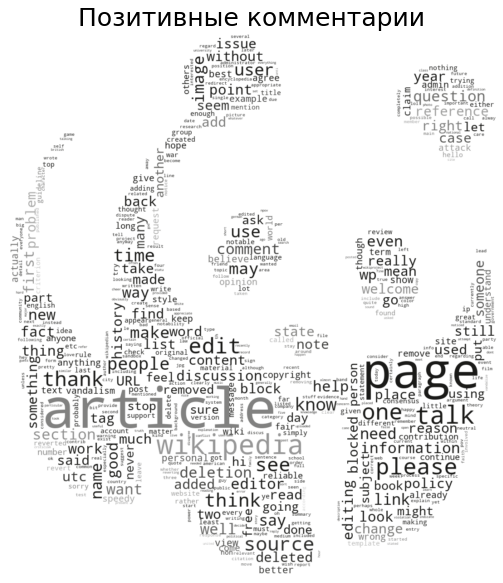

In [14]:
my_wordcloud('https://cdn1.ozone.ru/multimedia/1026554175.jpg',\
             df_toxic.query('toxic == 0')['clean'].apply(lambda x: ' '.join(x)),\
             'Позитивные комментарии')

Вроде все в порядке, но стоит отметить что к наиболее популярным словам относятся слова "wikipedia", "article" и "page", что говорит о том что в текстах содержится много отсылок к википедии. Выведем 500 наиболее часто встречаемых слов в негативных текстах

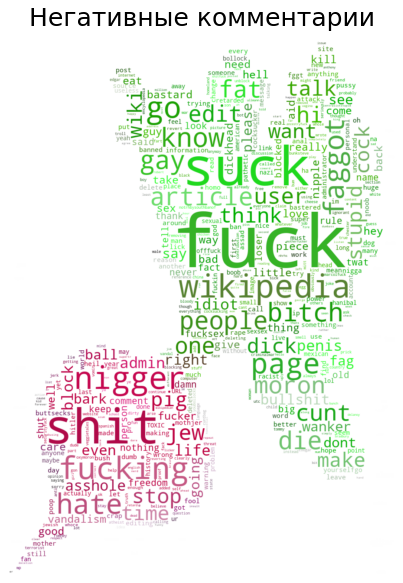

In [15]:
my_wordcloud('https://printonic.ru/uploads/images/2016/03/26/.tmb/thumb_img_56f6912e48526_resize_900_5000.jpg',\
             df_toxic.query('toxic == 1')['clean'].apply(lambda x: ' '.join(x)),\
             'Негативные комментарии')

Большинство слов ожидаемы, но как и в позитивных текстах, в негативных часто встречаются слова "wikipedia", "article" и "page". В дальнейшем, убрав эти слова из текстов я сравнил метрику F1 с ними и без них на логистической регрессии. Оказалось что F1 слегка проседает без использования этих слов. Приступим к обучению моделей.

## Обучение

Разделим данные на признаки и целевой признак с разделением на тренировочную и тестовую выборки в соотношении 17:3

In [16]:
corpus_tr_X, corpus_t_X, tr_y, t_y = train_test_split(df_toxic['clean'].astype('U'), df_toxic['toxic'],\
                                                      random_state=RAST, test_size=0.15, stratify=df_toxic['toxic'])

Подготовим шапку таблицы, в которую в дальнейшем будем сохранять результаты обучения и тестирования моделей

In [17]:
all_result = pd.DataFrame(columns=['Модель', 'Оптимальные параметры',\
                                   'F1 кросс-валидация', 'Время обучения, сек.', 'F1 тест', 'Время предсказания, сек.'])

Напишем функцию, которая:

- На вход получит признаки и целевой признак для обучения моделей, обучаемую модель и ее гиперпараметры для перебора
- Пропустит через кросс-валидатор GridSearchCV нашу выборку, разделяя их на 4 фолда, попутно cоздавая матрицу cо значениями TF-IDF по корпусу комментариев и масштабируя их, и перебирет предложенные гиперпараметры.
- Вернет таблицу с информацией о наименовании модели, наилучшими подобранными параметрами, среднее F1 по результатам кросс-валидации и время обучения модели.
- В отдельную переменную сохранит обученную модель

In [18]:
def my_pipe(X_tr, y_tr, classifier, classifier_name, params, results):
        steps = [('vectorizer', TfidfVectorizer()),\
                 ('normalizer', StandardScaler(with_mean=False)),\
                 ('model', classifier)]
        pipe = Pipeline(steps)
    
        time_start_fit = timeit.default_timer()
        grid_search = GridSearchCV(pipe, params, cv=4, scoring='f1',\
                                   n_jobs=-1, verbose=0, pre_dispatch='2 * n_jobs')
        grid_search.fit(X_tr, y_tr)
        time_fit = timeit.default_timer() - time_start_fit
            
        result = pd.DataFrame(data=[[classifier_name, grid_search.best_params_, round(grid_search.best_score_, 3),\
                                     round(time_fit, 3), None, None]],\
                              columns=['Модель', 'Оптимальные параметры',\
                                       'F1 кросс-валидация', 'Время обучения, сек.', 'F1 тест', 'Время предсказания, сек.'])
    
        display(result)
        return results.append(result, ignore_index=True), grid_search.best_estimator_

Проверим работу функции и за одно выведем результат работы константной модели, которая всегда будет предсказывать наличие негативного комментария

In [19]:
all_result, dummy = my_pipe(corpus_tr_X, tr_y, DummyClassifier(random_state=RAST, strategy='constant', constant=1),\
                            'Dummy', {}, all_result)

,Модель,Оптимальные параметры,F1 кросс-валидация,"Время обучения, сек.",F1 тест,"Время предсказания, сек."
0,Dummy,{},0.185,18.195,None,None


Запустим обучение 3-х моделей с подбором оптимальных гиперпараметров (на самом деле я перепробовал около 10 различных моделей, но только по этим 3-м моделям удалось превысить порог метрики F1 в 0.75) - Логистическую регрессию, ансамбль решающих деревьев и ансамбль Light Gradient Boosted Machine.

In [20]:
all_result, log_reg = my_pipe(corpus_tr_X, tr_y,\
                              LogisticRegression(random_state=RAST, solver='liblinear'),\
                              'LogisticRegression', {'vectorizer__max_features': [3000],\
                                                     'model__max_iter': [500]},\
                              all_result)

,Модель,Оптимальные параметры,F1 кросс-валидация,"Время обучения, сек.",F1 тест,"Время предсказания, сек."
0,LogisticRegression,"{'model__max_iter': 500, 'vectorizer__max_features': 3000}",0.757,46.177,None,None


In [21]:
all_result, forests = my_pipe(corpus_tr_X, tr_y, RandomForestClassifier(random_state=RAST), 'RandomForest',\
                              {'vectorizer__max_features': [4000], 'model__max_depth': [170],\
                               'model__n_estimators': [90], 'model__min_samples_split':[110],\
                               'model__class_weight':[{0:1, 1:2.8}]},\
                              all_result)

,Модель,Оптимальные параметры,F1 кросс-валидация,"Время обучения, сек.",F1 тест,"Время предсказания, сек."
0,RandomForest,"{'model__class_weight': {0: 1, 1: 2.8}, 'model__max_depth': 170, 'model__min_samples_split': 110, 'model__n_estimators': 90, 'vectorizer__max_features': 4000}",0.76,271.689,None,None


In [22]:
all_result, lgbm = my_pipe(corpus_tr_X, tr_y, LGBMClassifier(random_state=RAST, verbose=0, force_col_wise = True),\
                           'LGBM', {'model__feature_fraction': [0.3], 'model__scale_pos_weight': [3],\
                                    'model__learning_rate': [0.07], 'model__n_estimators': [400],\
                                    'model__num_leaves': [45]},\
                           all_result)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3


,Модель,Оптимальные параметры,F1 кросс-валидация,"Время обучения, сек.",F1 тест,"Время предсказания, сек."
0,LGBM,"{'model__feature_fraction': 0.3, 'model__learning_rate': 0.07, 'model__n_estimators': 400, 'model__num_leaves': 45, 'model__scale_pos_weight': 3}",0.79,268.034,None,None


In [23]:
display(all_result)

,Модель,Оптимальные параметры,F1 кросс-валидация,"Время обучения, сек.",F1 тест,"Время предсказания, сек."
0,Dummy,{},0.185,18.195,None,None
1,LogisticRegression,"{'model__max_iter': 500, 'vectorizer__max_features': 3000}",0.757,46.177,None,None
2,RandomForest,"{'model__class_weight': {0: 1, 1: 2.8}, 'model__max_depth': 170, 'model__min_samples_split': 110, 'model__n_estimators': 90, 'vectorizer__max_features': 4000}",0.760,271.689,None,None
3,LGBM,"{'model__feature_fraction': 0.3, 'model__learning_rate': 0.07, 'model__n_estimators': 400, 'model__num_leaves': 45, 'model__scale_pos_weight': 3}",0.790,268.034,None,None


Случайный лес и логистическая регрессия показали примерно одинаковый результат F1 по результатам кросс-валидации - 0.76, но при этом вторая модель обучается в разы быстрее. Лучший же результат F1-меры  показала модель с использованием градиентного бустинга - 0.79, с такими гиперпараметрами как: случайное подмножество объектов для каждой итерации - 30%, скорость обучения - 0.07, количество деревьев - 400, максимальное количество листьев дерева - 45, увеличение веса положительного класса до 3 при весе противоположного класса равном 1 . Приступим к финальному тестированию.

## Тестирование моделей и вывод

Проведем тестирование каждой модели

In [24]:
models = [log_reg, forests, lgbm]

for i in range(len(models)):
    time_start_pred = timeit.default_timer()
    pred = models[i].predict(corpus_t_X)
    all_result.iloc[i+1, 5] = round(timeit.default_timer() - time_start_pred, 3)
    all_result.iloc[i+1, 4] = round(f1_score(t_y, pred), 3)

***ВЫВОД:***

В процессе подготовки проекта мы загрузили данные и изучили их. В нашем распоряжении было 159571 текст с комментариями, размеченные на позитивные и негативные комментарии. Дубликаты отсутствовали, был обнаружен сильный дисбаланс в сторону отрицательного класса в соотношении 9:1. В текстах было обнаружено множество "загрязнений", таких как: цифровые и числовые значения, ссылки, различные символы и прочее. От всего этого тексты были очищены и проведена токенизация, после чего слова в тексте были приведены к лемме. Учитывая использование кросс-валидации, процесс создания признаков, а именно перевод корпуса текстов в векторное представление путем расчета оценок важности слов при помощи класса TfidfVectorizer() из библиотеки sklearn, был внесен в сам процесс кросс-валидации для его применения по отдельности на обучающей и валидационной частях. Тоже было сделано и для последующего масштабирования признаков. Мы обучили 3 модели - логистическую регрессию, ансамбль решающих деревьев и ансамбль Light Gradient Boosted Machine. По результатам кросс-валидации лучшей оказалась модель Light GBM c значением F1-меры - 0.79. Все три модели превысили допустимый нижний порог метрики в 0.75 на обучающей выборке и были проверены на тестовой. Посмотрим на результаты тестирования и сделаем заключение.

In [25]:
display(all_result)

,Модель,Оптимальные параметры,F1 кросс-валидация,"Время обучения, сек.",F1 тест,"Время предсказания, сек."
0,Dummy,{},0.185,18.195,None,None
1,LogisticRegression,"{'model__max_iter': 500, 'vectorizer__max_features': 3000}",0.757,46.177,0.76,1.09
2,RandomForest,"{'model__class_weight': {0: 1, 1: 2.8}, 'model__max_depth': 170, 'model__min_samples_split': 110, 'model__n_estimators': 90, 'vectorizer__max_features': 4000}",0.760,271.689,0.765,1.862
3,LGBM,"{'model__feature_fraction': 0.3, 'model__learning_rate': 0.07, 'model__n_estimators': 400, 'model__num_leaves': 45, 'model__scale_pos_weight': 3}",0.790,268.034,0.795,2.346


Результаты тестирования моделей почти не отличаются от результатов кросс-валидации, что говорит от том что мы избежали переобучения. Все 3 модели показали убедительный результат F1 - выше 0.75. Лучшей же моделью рекоммендуется считать модель LightGBM c значением F1-меры - 0.795 на тестовой выборке, если скорость обучения и предсказания не играет максимально важной роли.